# Timeseries Classification
[OliveOil](http://www.timeseriesclassification.com/Downloads/OliveOil.zip) dataset using **FCN** and **LSTM-FCN**.

In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0    118      0  0:00:05  0:00:05 --:--:--   162
    100% |████████████████████████████████| 5.7MB 7.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.0MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x631d0000 @  0x7f8ba91902a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), re

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pathlib
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

from fastai import *

In [4]:
!curl -O http://www.timeseriesclassification.com/Downloads/OliveOil.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  345k  100  345k    0     0   306k      0  0:00:01  0:00:01 --:--:--  306k


In [5]:
!unzip OliveOil.zip

Archive:  OliveOil.zip
  inflating: OliveOil.txt            
  inflating: OliveOil_TEST.arff      
  inflating: OliveOil_TEST.txt       
  inflating: OliveOil_TRAIN.arff     
  inflating: OliveOil_TRAIN.txt      


In [6]:
# read a text file of timeseries data into a pandas DataFrame
def txt2df(fname):
    raw = open(fname).readlines()
    raw = [map(float, each.strip().split()) for each in raw]
    df_data = list()
    for i in range(len(raw)):
        df_data.append(list(raw[i]))
    # column '0' contains the labels
    result = pd.DataFrame(df_data)
    result.astype({0: int})
    return result

df = txt2df('OliveOil_TRAIN.txt'); df.head()

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.0,-0.611375,-0.610586,-0.606557,-0.601132,-0.594315,-0.585762,-0.577419,-0.570175,-0.563285,...,-0.979553,-0.980385,-0.980328,-0.980220,-0.980691,-0.981337,-0.982336,-0.983213,-0.983672,-0.983120
1,1.0,-0.615392,-0.613729,-0.609228,-0.604315,-0.598768,-0.590507,-0.581617,-0.572926,-0.565374,...,-0.979210,-0.979335,-0.979523,-0.980038,-0.981146,-0.982332,-0.982570,-0.982630,-0.982850,-0.982549
2,1.0,-0.611999,-0.610500,-0.606374,-0.600445,-0.593084,-0.585245,-0.577118,-0.568827,-0.561596,...,-0.979514,-0.979663,-0.979964,-0.980563,-0.981326,-0.982744,-0.983107,-0.983033,-0.983956,-0.983858
3,1.0,-0.622784,-0.622222,-0.619049,-0.613251,-0.605889,-0.597508,-0.589047,-0.580697,-0.572822,...,-0.968819,-0.969902,-0.970586,-0.970718,-0.971197,-0.972268,-0.972654,-0.972861,-0.973671,-0.973614
4,1.0,-0.621793,-0.621272,-0.617298,-0.612074,-0.605472,-0.597607,-0.589165,-0.581424,-0.574620,...,-0.977420,-0.977831,-0.978376,-0.978778,-0.979656,-0.981148,-0.981796,-0.981331,-0.981289,-0.981331


In [7]:
df[0].unique()

array([1., 2., 3., 4.])

In [0]:
bs = 64

In [0]:
DATASET = 'OliveOil'
classes = 4

In [0]:
path = pathlib.Path('')

In [0]:
def one_hot_encode(input, labels):
    m = input.shape[0]
    output = np.zeros((m, labels), dtype=int)
    row_index = np.arange(m)
    output[row_index, input] = 1
    return output

def split_xy(data, classes):
    X = data[:, 1:]
    y = data[:, 0].astype(int)
    # hot encode
    #y = one_hot_encode(y, classes)
    return X, y

def create_dataset(X, y, device):
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.long, device=device)
    #y_tensor = torch.tensor(y, dtype=torch.float32, device=device)
    return TensorDataset(X_tensor, y_tensor)

def load_data(path, classes):
    data = np.loadtxt(path)
    return split_xy(data, classes)

The outputs of the model should be of size (minibatch, C). On the other hand the target `y` should contain the indices of the classes.

In [0]:
# load training dataset
X_train, y_train = load_data(path/'OliveOil_TRAIN.txt', classes) 

# load testing dataset
X_test, y_test = load_data(path/'OliveOil_TEST.txt', classes)

In [0]:
y_train = y_train - 1
y_test = y_test - 1

In [14]:
print('X_train %s   y_train %s   y_train type %s' % (X_train.shape, y_train.shape, y_train.dtype))
print('X_test  %s   y_test  %s   y_test  type %s' % (X_test.shape, y_test.shape, y_test.dtype))

X_train (30, 570)   y_train (30,)   y_train type int64
X_test  (30, 570)   y_test  (30,)   y_test  type int64


As the classes are imbalanced, get the count for each class, to use later in the sampling

In [15]:
for c in [1, 2, 3, 4]:
    c = c - 1
    class_count = (y_train==c).sum()
    print('Class %d occured %d and percentage %f' % (c, class_count, class_count/y_train.shape[0]))

Class 0 occured 5 and percentage 0.166667
Class 1 occured 8 and percentage 0.266667
Class 2 occured 4 and percentage 0.133333
Class 3 occured 13 and percentage 0.433333


load the numpy training and test sets into pytorch Dataset object

In [0]:
cuda = torch.device('cuda')     # Default CUDA device
cpu = torch.device('cpu')       # Default CPU device

In [17]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,-0.611895,-0.610648,-0.606697,-0.601020,-0.593792,-0.585476,-0.577100,-0.568880,-0.561298,-0.555327,...,-0.976487,-0.977011,-0.977404,-0.977851,-0.978500,-0.979447,-0.979884,-0.979993,-0.980466,-0.980602
std,0.007103,0.007094,0.007025,0.006931,0.007014,0.007098,0.007005,0.006994,0.007035,0.007000,...,0.006211,0.006145,0.006196,0.006212,0.006270,0.006313,0.006392,0.006372,0.006364,0.006407
min,-0.622784,-0.622222,-0.619049,-0.613251,-0.606484,-0.598921,-0.590348,-0.582025,-0.574668,-0.568545,...,-0.995849,-0.996575,-0.997365,-0.997696,-0.998277,-0.999678,-1.000187,-1.000031,-1.000642,-1.001061
25%,-0.615420,-0.614054,-0.609959,-0.604032,-0.596716,-0.588481,-0.579605,-0.571327,-0.563762,-0.557526,...,-0.978997,-0.979154,-0.979423,-0.979826,-0.980450,-0.981289,-0.982201,-0.982305,-0.982654,-0.982617
50%,-0.611913,-0.610543,-0.606757,-0.601161,-0.593762,-0.585272,-0.577268,-0.569677,-0.561556,-0.555934,...,-0.975869,-0.976176,-0.976744,-0.977298,-0.977871,-0.978881,-0.979175,-0.979325,-0.979627,-0.980093
75%,-0.609884,-0.608681,-0.604591,-0.599247,-0.591120,-0.582454,-0.574215,-0.565808,-0.558239,-0.551438,...,-0.972170,-0.973330,-0.973860,-0.974376,-0.974811,-0.975666,-0.976206,-0.976166,-0.976381,-0.976528
max,-0.590921,-0.589520,-0.586062,-0.582049,-0.575003,-0.566571,-0.559088,-0.551611,-0.544998,-0.539241,...,-0.968274,-0.968620,-0.968871,-0.969230,-0.970103,-0.971065,-0.971451,-0.971528,-0.971549,-0.971597


In [0]:
train_ds = create_dataset(X_train, y_train, cuda)
test_ds  = create_dataset(X_test, y_test, cuda)

pass the Dataset objects into a DataLoader

In [0]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)#, sampler = sampler)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

## LSTM-FCN
### LSMT block
A shuffle layer + LSTM layer + Dropout layer

In [0]:
class BlockLSTM(nn.Module):
    def __init__(self, time_steps, num_layers, lstm_hs, dropout=0.8, attention=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=time_steps, hidden_size=lstm_hs, num_layers=num_layers)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        # input is of the form (batch_size, num_layers, time_steps), e.g. (128, 1, 512)
        x = torch.transpose(x, 0, 1)
        # lstm layer is of the form (num_layers, batch_size, time_steps)
        x, (h_n, c_n) = self.lstm(x)
        # dropout layer input shape (Sequence Length, Batch Size, Hidden Size * Num Directions)
        y = self.dropout(x)
        # output shape is same as Dropout intput
        return y

### FCN block

#### Convolutional block

In [0]:
class BlockFCNConv(nn.Module):
    def __init__(self, in_channel=1, out_channel=128, kernel_size=8, momentum=0.99, epsilon=0.001, squeeze=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size)
        self.batch_norm = nn.BatchNorm1d(num_features=out_channel, eps=epsilon, momentum=momentum)
        self.relu = nn.ReLU()
    def forward(self, x):
        # input (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
        x = self.conv(x)
        # input (batch_size, out_channel, L_out)
        x = self.batch_norm(x)
        # same shape as input
        y = self.relu(x)
        return y

#### FCN block

In [0]:
class BlockFCN(nn.Module):
    def __init__(self, time_steps, channels=[1, 128, 256, 128], kernels=[8, 5, 3], mom=0.99, eps=0.001):
        super().__init__()
        self.conv1 = BlockFCNConv(channels[0], channels[1], kernels[0], momentum=mom, epsilon=eps, squeeze=True)
        self.conv2 = BlockFCNConv(channels[1], channels[2], kernels[1], momentum=mom, epsilon=eps, squeeze=True)
        self.conv3 = BlockFCNConv(channels[2], channels[3], kernels[2], momentum=mom, epsilon=eps)
        output_size = time_steps - sum(kernels) + len(kernels)
        self.global_pooling = nn.AvgPool1d(kernel_size=output_size)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # apply Global Average Pooling 1D
        y = self.global_pooling(x)
        return y

### FCN
Fully convolutional network, without LSTM

In [0]:
class FCN(nn.Module):
    def __init__(self, time_steps, num_variables, channels=[1, 128, 256, 128]):
        super().__init__()
        self.fcn = BlockFCN(time_steps, channels)
        self.dense = nn.Linear(channels[-1], num_variables)
        
    def forward(self, x):
        # input is (batch_size, time_steps), it has to be (batch_size, 1, time_steps)
        x = x.unsqueeze(1)
        # pass through the FCN block
        x = self.fcn(x)
        x = torch.squeeze(x)
        # pass through a linear layer
        y = self.dense(x)
        return x

### LSTM-FCN
Fully convolutional network, without LSTM

In [0]:
class LSTMFCN(nn.Module):
    def __init__(self, time_steps, num_variables=1, lstm_hs=256, channels=[1, 128, 256, 128]):
        super().__init__()
        self.lstm_block = BlockLSTM(time_steps, 1, lstm_hs)
        self.fcn_block = BlockFCN(time_steps)
        self.dense = nn.Linear(channels[-1] + lstm_hs, num_variables)
        self.softmax = nn.LogSoftmax(dim=1) #nn.Softmax(dim=1)
    def forward(self, x):
        # input is (batch_size, time_steps), it has to be (batch_size, 1, time_steps)
        x = x.unsqueeze(1)
        # pass input through LSTM block
        x1 = self.lstm_block(x)
        x1 = torch.squeeze(x1)
        # pass input through FCN block
        x2 = self.fcn_block(x)
        x2 = torch.squeeze(x2)
        # concatenate blocks output
        x = torch.cat([x1, x2], 1)
        # pass through Linear layer
        x = self.dense(x)
        # pass through Softmax activation
        y = x#y = torch.squeeze(x)#y = self.softmax(x)
        return y

## Training

In [31]:
time_steps = X_train.shape[1]
num_variables = classes

time_steps, num_variables

(570, 4)

In [0]:
model = LSTMFCN(time_steps, num_variables).cuda()

look at the different blocks of the Model

In [0]:
# model summary
for m in model.children():
    print(m.training)#, m)
    for j in m.children():
        print(j.training, j)

True
True LSTM(570, 256)
True Dropout(p=0.8)
True
True BlockFCNConv(
  (conv): Conv1d(1, 128, kernel_size=(8,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (batch_norm): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True AvgPool1d(kernel_size=(557,), stride=(557,), padding=(0,))
True
True


look at the parameters (i.e. weights) in each layer

In [0]:
[p.shape for p in model.parameters()]

[torch.Size([1024, 570]),
 torch.Size([1024, 256]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([128, 1, 8]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([256, 128, 5]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([128, 256, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([4, 384]),
 torch.Size([4])]

Define a learner class to automate the learning process

In [0]:
class SimpleLearner():
    def __init__(self, data, model, loss_func, wd = 1e-5):
        self.data, self.model, self.loss_func = data, model, loss_func
        self.wd = wd
    
    def update_manualgrad(self, x,y,lr):
        y_hat = self.model(x)
        # weight decay
        w2 = 0.
        for p in model.parameters(): w2 += (p**2).sum()
        # add to regular loss
        loss = self.loss_func(y_hat, y) + w2 * self.wd
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p.sub_(lr * p.grad)
                p.grad.zero_()
        return loss.item()

    def update(self, x,y,lr):
        opt = optim.Adam(self.model.parameters(), lr)
        y_hat = self.model(x)
        loss = self.loss_func(y_hat, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        return loss.item()

    def fit(self, epochs=1, lr=1e-3):
        """Train the model"""
        losses = []
        for i in tqdm(range(epochs)):
            for x,y in self.data[0]:
                current_loss = self.update(x, y , lr)
                losses.append(current_loss)
        return losses
    
    def evaluate(self, X):
        """Evaluate the given data loader on the model and return predictions"""
        result = None
        for x, y in X:
            y_hat = self.model(x)
            result = y_hat if result is None else np.concatenate((result, y_hat), axis=0)
        return result

In [0]:
#num_variables = 1

In [0]:
model = LSTMFCN(time_steps, num_variables).cuda()

train the model using the DataLoader

In [0]:
# depending on the number of classes, use a Binary Cross Entropy or a Negative Log Likelihood loss for more than two classes
#loss_func = nn.NLLLoss().cuda() # weight=weights
#loss_func = nn.BCEWithLogitsLoss().cuda()
loss_func = nn.CrossEntropyLoss().cuda()
acc_func = accuracy # accuracy_thresh

In [0]:
lr = 2e-2
learner = SimpleLearner([train_dl, test_dl], model, loss_func)
losses = learner.fit(10)

100%|██████████| 10/10 [00:00<00:00, 24.67it/s]


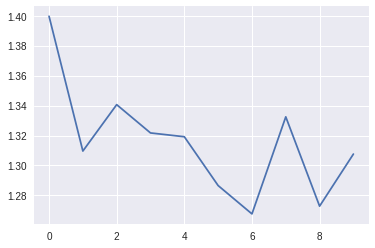

In [0]:
plt.plot(losses)

In [0]:
y_pred = learner.evaluate(test_dl)

In [0]:
if num_variables==2:
    ((y_test - y_pred.argmax(axis=1))**2).mean()
else:
    ((y_test - y_pred)**2).mean()

#### Training LSTMFCN with fastai

In [0]:
model = LSTMFCN(time_steps, num_variables, lstm_hs=128, channels=[1, 128, 128, 128]).cuda()

In [0]:
data = DataBunch(train_dl=train_dl, valid_dl=test_dl, path=path)
learner = Learner(data, model, loss_func=loss_func, metrics=acc_func, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


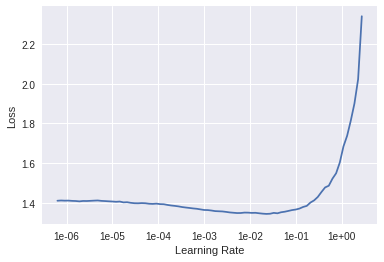

In [0]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit(50, lr=3e-3)

epoch,train_loss,valid_loss,accuracy
1,1.396385,1.359485,0.400000
2,1.381889,1.357261,0.400000
3,1.372547,1.333944,0.400000
4,1.369740,1.322976,0.400000
5,1.353715,1.312739,0.400000
6,1.356948,1.308630,0.400000
7,1.347808,1.304727,0.400000
8,1.349517,1.301207,0.400000
9,1.352698,1.298808,0.400000
10,1.349861,1.297599,0.400000


In [0]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy
1,1.262412,1.297237,0.400000
2,1.276047,1.296188,0.400000
3,1.273078,1.294888,0.400000
4,1.280526,1.299112,0.400000
5,1.283353,1.303249,0.400000
6,1.301668,1.297865,0.400000
7,1.298818,1.295340,0.400000
8,1.296389,1.294743,0.400000
9,1.285329,1.294697,0.400000
10,1.283528,1.294878,0.400000


In [0]:
learner.get_preds(DatasetType.Valid)

[tensor([[0.1616, 0.2780, 0.1322, 0.4282],
         [0.1625, 0.2776, 0.1329, 0.4270],
         [0.1632, 0.2772, 0.1329, 0.4267],
         [0.1628, 0.2773, 0.1328, 0.4271],
         [0.1626, 0.2775, 0.1327, 0.4273],
         [0.1615, 0.2780, 0.1322, 0.4283],
         [0.1618, 0.2779, 0.1323, 0.4280],
         [0.1622, 0.2777, 0.1325, 0.4275],
         [0.1623, 0.2776, 0.1325, 0.4276],
         [0.1615, 0.2780, 0.1321, 0.4283],
         [0.1621, 0.2777, 0.1324, 0.4278],
         [0.1633, 0.2772, 0.1330, 0.4265],
         [0.1618, 0.2779, 0.1323, 0.4279],
         [0.1622, 0.2777, 0.1325, 0.4276],
         [0.1612, 0.2781, 0.1319, 0.4288],
         [0.1652, 0.2764, 0.1352, 0.4231],
         [0.1623, 0.2777, 0.1331, 0.4269],
         [0.1624, 0.2776, 0.1328, 0.4273],
         [0.1613, 0.2780, 0.1319, 0.4288],
         [0.1610, 0.2781, 0.1318, 0.4291],
         [0.1620, 0.2776, 0.1322, 0.4281],
         [0.1615, 0.2779, 0.1320, 0.4287],
         [0.1616, 0.2778, 0.1320, 0.4286],
         [0

In [0]:
learner.get_preds(DatasetType.Train)

[tensor([[0.1642, 0.2768, 0.1338, 0.4252],
         [0.1633, 0.2772, 0.1331, 0.4264],
         [0.1634, 0.2770, 0.1331, 0.4264],
         [0.1623, 0.2776, 0.1324, 0.4276],
         [0.1638, 0.2770, 0.1333, 0.4260],
         [0.1625, 0.2775, 0.1328, 0.4272],
         [0.1620, 0.2778, 0.1324, 0.4277],
         [0.1619, 0.2779, 0.1324, 0.4279],
         [0.1620, 0.2777, 0.1326, 0.4277],
         [0.1621, 0.2777, 0.1324, 0.4277],
         [0.1612, 0.2783, 0.1321, 0.4284],
         [0.1618, 0.2780, 0.1324, 0.4278],
         [0.1623, 0.2777, 0.1325, 0.4276],
         [0.1605, 0.2785, 0.1318, 0.4292],
         [0.1609, 0.2783, 0.1319, 0.4289],
         [0.1658, 0.2760, 0.1354, 0.4228],
         [0.1657, 0.2762, 0.1355, 0.4226],
         [0.1616, 0.2779, 0.1322, 0.4283],
         [0.1617, 0.2778, 0.1320, 0.4285],
         [0.1616, 0.2778, 0.1320, 0.4286],
         [0.1609, 0.2782, 0.1318, 0.4291],
         [0.1619, 0.2777, 0.1321, 0.4283],
         [0.1614, 0.2780, 0.1320, 0.4287],
         [0

In [0]:
learner.predict(data)

AttributeError: ignored

#### Training one cycle

In [0]:
data = DataBunch(train_dl=train_dl, valid_dl=test_dl, path=path)
learner = Learner(data, model, loss_func=loss_func, metrics=accuracy)
learner.fit(10, lr=5e-5)

Total time: 00:03
epoch  train_loss  valid_loss  accuracy
1      0.003275    0.785197    0.762590  (00:00)
2      0.003349    0.800480    0.762590  (00:00)
3      0.003107    0.804093    0.762590  (00:00)
4      0.002767    0.812344    0.762590  (00:00)
5      0.002825    0.806561    0.762590  (00:00)
6      0.002692    0.815485    0.755396  (00:00)
7      0.002587    0.823958    0.755396  (00:00)
8      0.002495    0.824159    0.755396  (00:00)
9      0.002463    0.840908    0.755396  (00:00)
10     0.002364    0.839903    0.755396  (00:00)



In [0]:
model.eval()
model.train()

LSTMFCN(
  (lstm_block): BlockLSTM(
    (lstm): LSTM(512, 256)
    (dropout): Dropout(p=0.8)
  )
  (fcn_block): BlockFCN(
    (conv1): BlockFCNConv(
      (conv): Conv1d(1, 128, kernel_size=(8,), stride=(1,))
      (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): BlockFCNConv(
      (conv): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
      (batch_norm): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv3): BlockFCNConv(
      (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
      (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (global_pooling): AvgPool1d(kernel_size=(499,), stride=(499,), padding=(0,))
  )
  (dense): Linear(in_features=384, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

#### Training FCN with fastai

In [0]:
model = FCN(time_steps, num_variables, channels=[1, 128, 128, 128]).cuda()

In [0]:
data = DataBunch(train_dl=train_dl, valid_dl=test_dl, path=path)
learner = Learner(data, model, loss_func=loss_func, metrics=acc_func, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


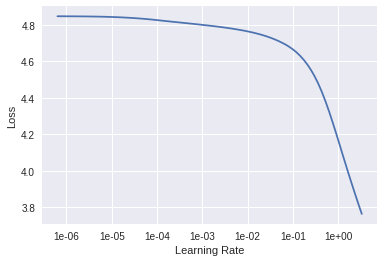

In [38]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [39]:
learner.fit(20, lr=2e-1)

epoch,train_loss,valid_loss,accuracy
1,4.848471,9362.541992,0.000000
2,4.678171,8.022126,0.300000
3,4.535940,3.657778,0.300000
4,4.411295,3.783348,0.300000
5,4.296944,3.580990,0.300000
6,4.188212,3.480293,0.300000
7,4.082968,3.350697,0.300000
8,3.979819,3.216700,0.300000
9,3.878839,3.077576,0.300000
10,3.780241,2.945386,0.300000


In [40]:
learner.fit(20, lr=2e-1)

epoch,train_loss,valid_loss,accuracy
1,1.865334,2.009843,0.400000
2,1.842530,1.645256,0.166667
3,1.812007,1.605217,0.300000
4,1.783988,1.557957,0.300000
5,1.758050,1.537399,0.300000
6,1.733743,1.529356,0.300000
7,1.711209,1.528689,0.300000
8,1.690359,1.534454,0.400000
9,1.670846,1.490387,0.400000
10,1.652645,1.460516,0.400000


In [41]:
learner.fit(50, lr=2e-1)

epoch,train_loss,valid_loss,accuracy
1,1.375397,2.807863,0.133333
2,1.416959,2.409551,0.166667
3,1.408806,1.492739,0.166667
4,1.402600,1.426170,0.400000
5,1.398951,1.465792,0.400000
6,1.396128,1.427471,0.400000
7,1.393576,1.408675,0.400000
8,1.390983,1.447512,0.300000
9,1.388283,1.529733,0.300000
10,1.385632,1.394419,0.400000
